# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19



Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [11]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [12]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [13]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform): #we are perform data augmentation for training images. The test images are not augmented but converted to tensors and normalised
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {} # we are putting this in a dictionary
        self.class_names = ['normal','viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self): #returning the length of whole directory
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index): # we are doing this beacause for index out of bounds
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name],image_name)
        image = Image.open(image_path).convert('RGB') #since we are using Resnet - 18
        return self.transform(image), self.class_names.index(class_name)
        
        
        #getitem will transform the image and return with transformed image, class name we are doing this beacuse pytorch doesn't understand pil imagesadn need to be converted to tensors

# Image Transformations

In [14]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)), #we are re sizing to 224*224 beacuse of the pretrained model
    torchvision.transforms.RandomHorizontalFlip(), #we are doing horizontal flip for the images
    torchvision.transforms.ToTensor(), #converting image to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456,0.406], std = [0.229,0.224,0.225]) # normalising it, these numbers come because normalisation done on imagenet images when pytorch and resnet 18 was created on that dataset
     
])

#We can do the same for the test dataset but we do not perform horizontal flip i.e Image Augmentation

In [15]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)), #we are re sizing to 224*224 beacuse of the pretrained model
    torchvision.transforms.ToTensor(), #converting image to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456,0.406], std = [0.229,0.224,0.225]) # normalising it, these numbers come because normalisation done on imagenet images when pytorch and resnet 18 was created on that dataset
     
])


# Prepare DataLoader

In [16]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [17]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs,test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [18]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 470
Num of test batches 15


# Data Visualization

In [19]:
class_names = train_dataset.class_names #we get the class names from train dataset

def show_images(images,labels,preds): #we are creating a function to show images
    plt.figure(figsize=(8,4))
    for i,image in enumerate(images):
        plt.subplot(1,6,i+1,xticks=[],yticks=[]) #numbering starts from 1 and batch size is 6
        image = image.numpy().transpose((1,2,0)) #tensors needed to be converted,we are doing it because of resnet - 18
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225]) #standard deviation
        image = image*std + mean #converting to pixel values that were there before normalization
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
        
    plt.tight_layout()
    plt.show()

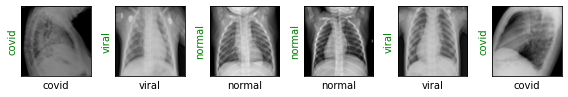

In [20]:
images, labels = next(iter(dl_train))
show_images(images,labels,labels) #since we don't have predictions we use labels

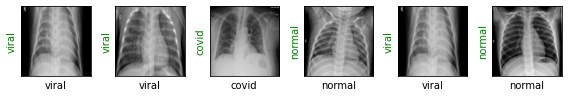

In [21]:
images, labels = next(iter(dl_test))
show_images(images,labels,labels)

# Creating the Model

In [22]:
resnet18 = torchvision.models.resnet18(pretrained = True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
#the resnet18 model has input features as 512 and output features as 1000 that we need to change
resnet18.fc = torch.nn.Linear(in_features = 512,out_features = 3) #nn means neural network
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #lr is learning rate


In [26]:
def show_preds():
    resnet18.eval()
    images,labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs,1) #it returns both index and prediction, we want only predictions
    show_images(images,labels,preds)

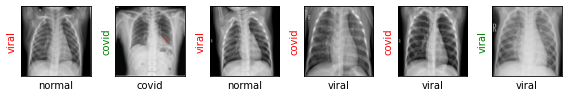

In [27]:
show_preds()

# Training the Model

In [29]:
def train(epochs):
    print('Starting training...')
    for e in range(0,epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        resnet18.train()
        
        for train_step, (images,labels) in enumerate(dl_train):
            optimizer.zero_grad() #clearing the optimizer
            outputs = resnet18(images)
            loss = loss_fn(outputs,labels)
            loss.backward() #back propagation
            optimizer.step() #to complete gradient step
            train_loss += loss.item()
            
            if train_step % 20 ==0:
                print('Evaluating at step', train_step)
                acc = 0. #accuracy is 0
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images,labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs,labels)
                    val_loss += loss.item()
                    
                    _,preds = torch.max(outputs,1)
                    acc += sum((preds == labels).numpy())
                
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance satisfied')
                    return
                
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
        
                      
        

Starting training...
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.1996, Acc: 0.3444


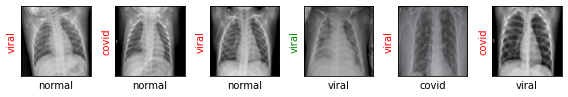

Evaluating at step 20
Val loss: 0.6815, Acc: 0.6889


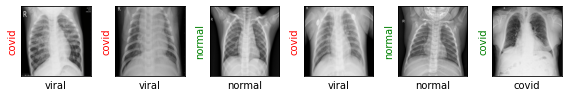

Evaluating at step 40
Val loss: 0.3607, Acc: 0.8889


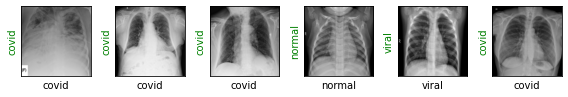

Evaluating at step 60
Val loss: 0.1617, Acc: 0.9444


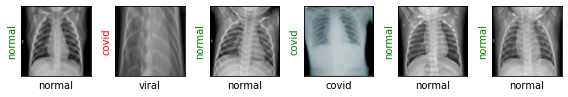

Evaluating at step 80
Val loss: 0.1455, Acc: 0.9556


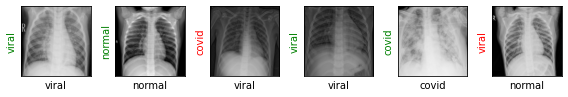

Performance satisfied


In [30]:
train(epochs = 1)

# Final Results

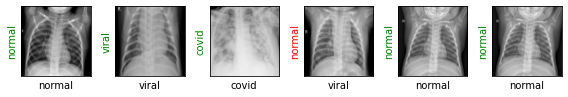

In [31]:
show_preds()